In [7]:
import pandas as pd
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
# No keys required for crypto data
client = CryptoHistoricalDataClient()

In [9]:
# Creating request object
tf = TimeFrame(amount=4, unit=TimeFrameUnit.Hour)

request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD"],
  timeframe=tf,
  start=datetime(2025, 5, 1),
  end=datetime(2025, 5, 27)
)

In [11]:
# Retrieve daily bars for Bitcoin in a DataFrame and printing it
btc_bars = client.get_crypto_bars(request_params)
btc_df = btc_bars.df

In [13]:



#data.set_index('timestamp', inplace=True)

# Farbe der Candle
btc_df['color'] = btc_df.apply(lambda row: 'green' if row['close'] > row['open'] else 'red', axis=1)



In [18]:

# Logik zur Erkennung von Strong Highs und Strong Lows
structure = []
candidate_WH = None
candidate_WL = None
strong_high = None
strong_low = None
up_count = 0
down_count = 0

for i in range(1, len(btc_df)):
    prev = btc_df.iloc[i - 1]
    curr = btc_df.iloc[i]

    # Zähle gleiche Farben
    if curr['color'] == 'green' and prev['color'] == 'green':
        up_count += 1
        down_count = 0
        # Prüfe auf potenzielles Hoch
        if curr['high'] > prev['high']:
            candidate_high = curr
    elif curr['color'] == 'red' and prev['color'] == 'red':
        down_count += 1
        up_count = 0
        # Prüfe auf potenzielles Tief
        if curr['low'] < prev['low']:
            candidate_low = curr
    else:
        up_count = 0
        down_count = 0

    # Weak High setzen
    if candidate_high is not None and curr['color'] == 'red' and prev['color'] == 'red':
        candidate_WH = {'time': candidate_high.name, 'price': candidate_high['high']}
        candidate_high = None

    # Weak Low setzen
    if candidate_low is not None and curr['color'] == 'green' and prev['color'] == 'green':
        new_WL = {'time': candidate_low.name, 'price': candidate_low['low']}

        # Wenn es ein Weak High gibt, dann wird es jetzt zu Strong High
        if candidate_WH is not None:
            # Promotion WH zu SH
            strong_high = candidate_WH
            structure.append({'type': 'Strong High', 'time': strong_high['time'], 'price': strong_high['price']})
            candidate_WH = None  # WH wurde promoted zu SH

        # Jetzt WL setzen oder überschreiben, wenn neues WL tiefer
        if candidate_WL is None:
            candidate_WL = new_WL
        else:
            if new_WL['price'] < candidate_WL['price']:
                candidate_WL = new_WL

        candidate_low = None

    # Wenn ein neues Weak High kommt, prüfen ob es höher ist als das letzte Strong High
    if candidate_high is not None and curr['color'] == 'red' and prev['color'] == 'red':
        new_WH = {'time': candidate_high.name, 'price': candidate_high['high']}

        if strong_high is not None:
            if new_WH['price'] > strong_high['price']:
                # Neues WH ist höher als das letzte SH → könnte promoted werden
                candidate_WH = new_WH
            else:
                # Tieferes WH — bleibt als candidate_WH aber überschreibt nicht SH
                candidate_WH = new_WH
        else:
            # Falls noch kein SH existiert
            candidate_WH = new_WH

        candidate_high = None

# Abschluss: letztes Weak Low auch abspeichern, wenn kein weiteres Event mehr kam
if candidate_WL is not None:
    structure.append({'type': 'Weak Low', 'time': candidate_WL['time'], 'price': candidate_WL['price']})



NameError: name 'candidate_low' is not defined

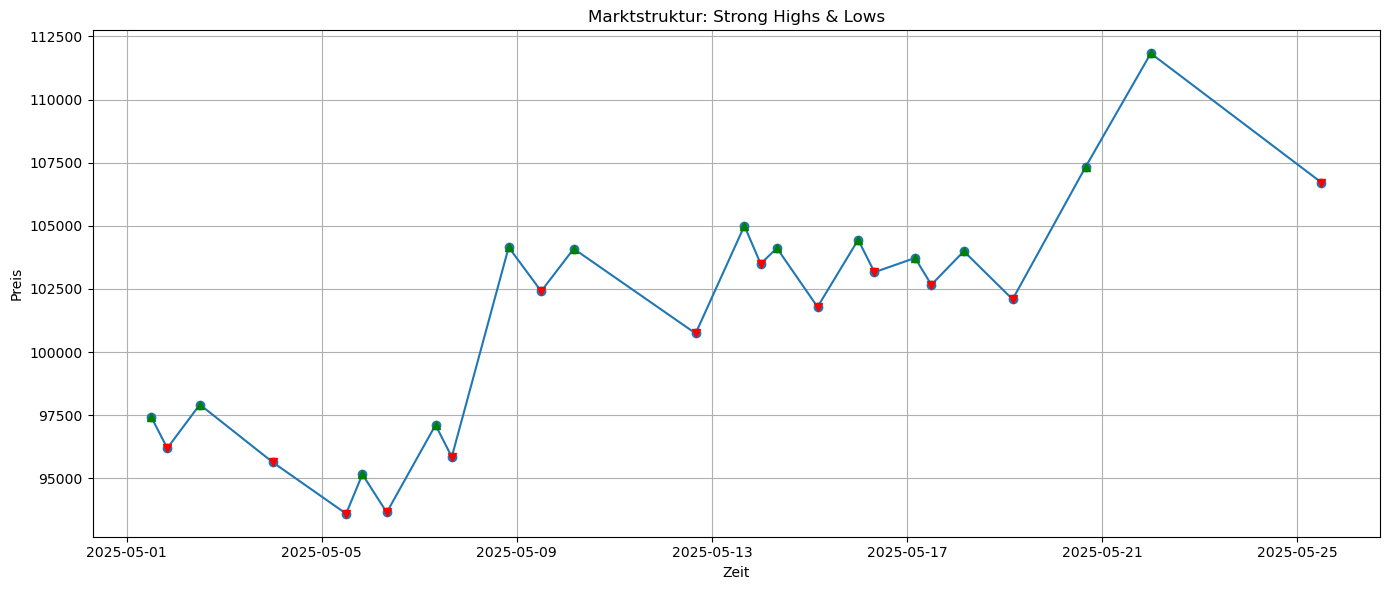

In [13]:


# Optional: Konvertiere Zeitstempel, falls nötig
structure_df['time'] = pd.to_datetime(structure_df['time'].apply(lambda x: x[1]))  # extrahiere Zeit aus Tuple
#structure_df['symbol'] = structure_df['time'].apply(lambda x: x[0])  # extrahiere Symbol, falls gebraucht

structure_df['time'] = pd.to_datetime(structure_df['time'])  # falls noch nötig

structure_df_sorted = structure_df.sort_values('time')

plt.figure(figsize=(14, 6))
plt.plot(structure_df_sorted['time'], structure_df_sorted['price'], marker='o', linestyle='-')

# Labels
plt.title("Marktstruktur: Strong Highs & Lows")
plt.xlabel("Zeit")
plt.ylabel("Preis")
plt.grid(True)

# Optional: farbige Marker je nach Typ
for i, row in structure_df_sorted.iterrows():
    if row['type'] == 'Strong High':
        plt.plot(row['time'], row['price'], marker='^', color='green')
    elif row['type'] == 'Strong Low':
        plt.plot(row['time'], row['price'], marker='v', color='red')

plt.tight_layout()
plt.show()


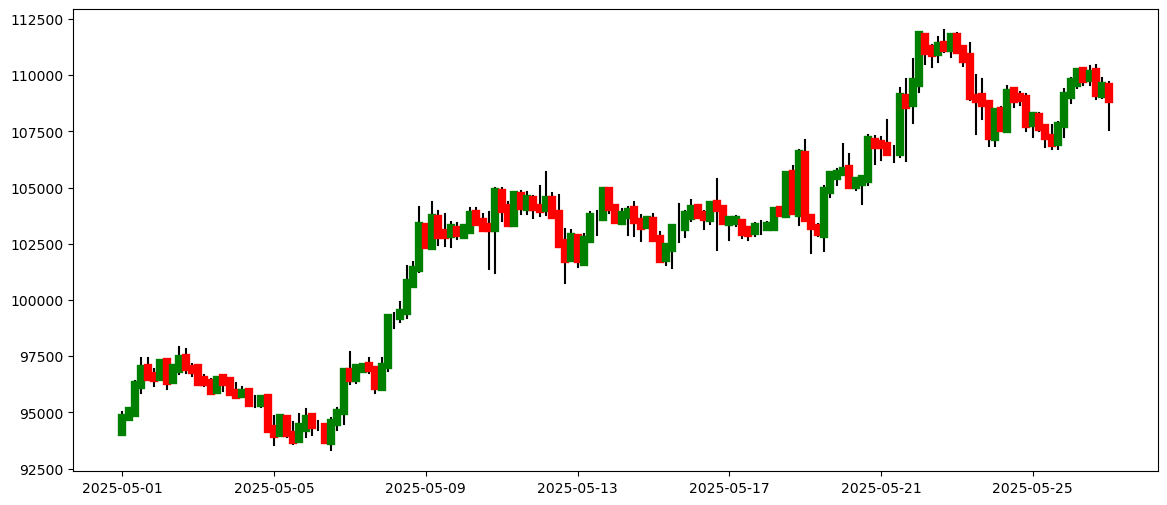

In [15]:





btc_df = btc_df.reset_index()
# Plot vorbereiten
fig, ax = plt.subplots(figsize=(14, 6))

for idx, row in btc_df.iterrows():
    color = 'green' if row['close'] >= row['open'] else 'red'
    ax.plot([row['timestamp'], row['timestamp']], [row['low'], row['high']], color='black')  # Docht
    ax.plot([row['timestamp'], row['timestamp']], [row['open'], row['close']], color=color, linewidth=6)  # Körper


In [17]:
print(btc_df.columns)
print(structure_df.columns)

Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'trade_count', 'vwap', 'color'],
      dtype='object')
Index(['type', 'time', 'price'], dtype='object')


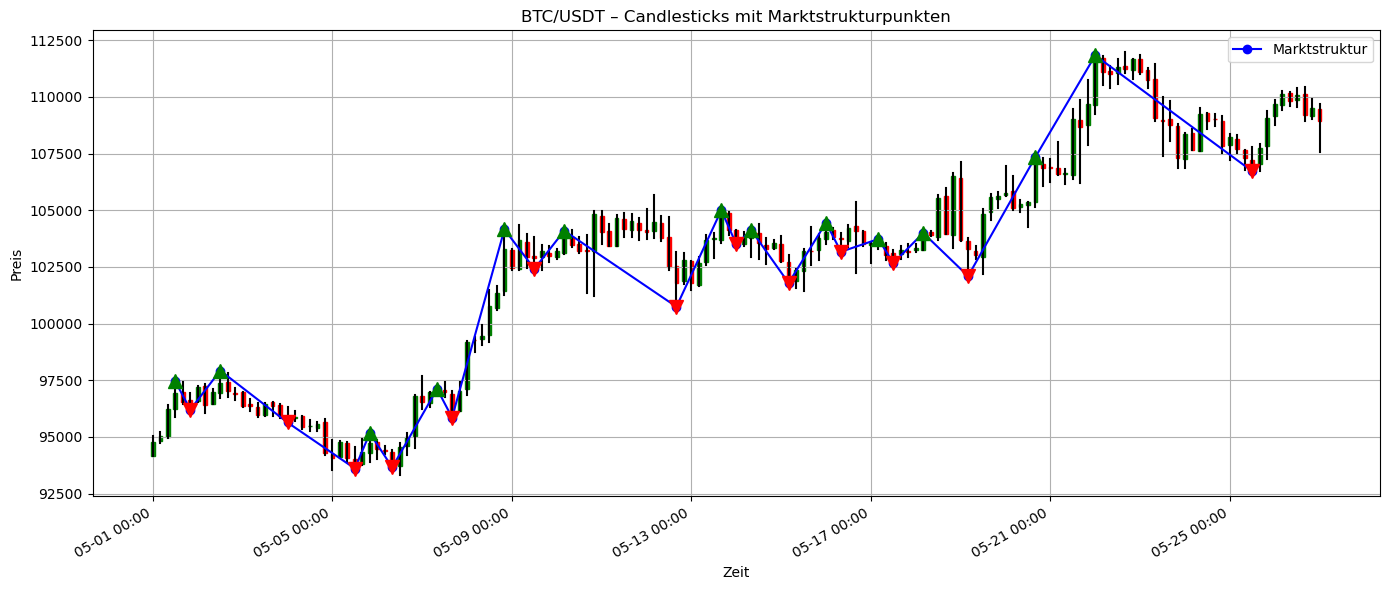

In [20]:
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])  # Sicherheit

# Strukturpunkte 'time' aufbereiten (Tuple entpacken falls nötig)
structure_df['time'] = structure_df['time'].apply(lambda x: x[1] if isinstance(x, tuple) else x)
structure_df['time'] = pd.to_datetime(structure_df['time'])

# Schritt 2: Plot aufsetzen
fig, ax = plt.subplots(figsize=(14, 6))

# Breite der Kerze in Zeit
candle_width = pd.Timedelta(hours=2)  # bei 15-Minuten-Candles etwas kleiner für Abstand

# Schritt 3: Candlesticks zeichnen
for idx, row in btc_df.iterrows():
    color = 'green' if row['close'] >= row['open'] else 'red'
    lower = min(row['open'], row['close'])
    height = abs(row['close'] - row['open'])

    # Rechteck für Candle-Body
    rect = mpatches.Rectangle(
        (row['timestamp'] - candle_width / 2, lower),  # (x, y) Startpunkt
        candle_width,  # Breite
        height,        # Höhe
        color=color
    )
    ax.add_patch(rect)

    # Docht (Wick)
    ax.plot([row['timestamp'], row['timestamp']], [row['low'], row['high']], color='black')

# Schritt 4: Strukturpunkte als Linie verbinden
structure_sorted = structure_df.sort_values('time')
ax.plot(structure_sorted['time'], structure_sorted['price'], linestyle='-', marker='o', color='blue', label='Marktstruktur')

# Schritt 5: Strukturpunkte markieren
for _, row in structure_sorted.iterrows():
    if row['type'] == 'Strong High':
        ax.plot(row['time'], row['price'], marker='^', color='green', markersize=10)
    elif row['type'] == 'Strong Low':
        ax.plot(row['time'], row['price'], marker='v', color='red', markersize=10)

# Schritt 6: Formatierungen
ax.set_title('BTC/USDT – Candlesticks mit Marktstrukturpunkten')
ax.set_xlabel('Zeit')
ax.set_ylabel('Preis')
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()